In [ ]:
#import functions
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import math
import pandas as pd
import torch.nn.functional as F
import random
import torch.optim as optim
from scipy.io import loadmat
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import scipy.io

In [ ]:
from scipy import signal

In [ ]:
import torch

try:
    version = torch.__version__
    print(f"PyTorch version: {version}")
except AttributeError:
    print("PyTorch version attribute is not available.")

PyTorch version: 2.4.1+cu121


In [ ]:
# To remove all files and directories in the /content folder
#!rm -rf /content/*

# Data Analysis

## Import Data

In [ ]:
tlds = torch.tensor((pd.read_csv('tlds.csv',header=None)).values)[:-1]
tlgs = torch.tensor((pd.read_csv('tlgs.csv',header=None)).values)[:-1]
taus = torch.tensor((pd.read_csv('taus.csv',header=None)).values)[:-1]
kps = torch.tensor((pd.read_csv('kps.csv',header=None)).values)[:-1]

p = torch.tensor((pd.read_csv('pilotoutput.csv',header=None)).values)[:-1]
pitch_error = torch.tensor((pd.read_csv('pitcherror.csv',header=None)).values)[:-1]
pitch_cmd = torch.tensor((pd.read_csv('pitchcmd.csv',header=None)).values)[:-1]
pitch_out = torch.tensor((pd.read_csv('pitchoutput.csv',header=None)).values)[:-1]

#xp = torch.tensor((pd.read_csv('xpilot.csv')).values)[:-1]

Ts = 0.1
Tfinal = 100
length = Tfinal/Ts
time = torch.arange(0, Tfinal + Ts, Ts)[:-1].view(-1,1)

In [ ]:
# Check the shapes
tlds.shape, tlgs.shape, taus.shape, kps.shape, p.shape, pitch_error.shape, pitch_cmd.shape, pitch_out.shape, time.shape

(torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 1]))

## Check for outliers

In [ ]:
# Check if each column of tensor1 is larger than the corresponding column of tensor2
is_column_larger = tlgs > tlds

# Check if all columns of tensor1 are larger than corresponding columns of tensor2
are_all_columns_larger = torch.all(is_column_larger, dim=0)

print("Are all columns of tlgs larger than corresponding columns of tlds:", torch.all(are_all_columns_larger).item())

Are all columns of tlgs larger than corresponding columns of tlds: True


In [ ]:

# Threshold value
threshold = 1.7

# Find the maximum value of each column
max_values, _ = torch.max(pitch_out, dim=0)

# Obtain the column numbers where the maximum value exceeds the threshold
columns_above_threshold = torch.nonzero(max_values > threshold).squeeze()

print("Column numbers where max value exceeds the threshold:", columns_above_threshold.tolist())

# Create a mask to select columns to keep
mask = torch.ones(pitch_out.size(1), dtype=torch.bool)
mask[columns_above_threshold] = False

# Delete columns based on the mask
pitch_out_filtered = pitch_out[:, mask]


tlds_filtered = tlds[:,mask]
tlgs_filtered = tlgs[:,mask]
taus_filtered = taus[:,mask]
kps_filtered=kps[:,mask]
p_filtered = p[:,mask]
pitch_cmd_filtered = pitch_cmd[:,mask]
pitch_error_filtered = pitch_error[:,mask]
#xp_filtered = xp[:,mask]

pitch_out_filtered.shape, tlds_filtered.shape, tlgs_filtered.shape, kps_filtered.shape,p_filtered.shape, pitch_cmd_filtered.shape,pitch_error_filtered.shape


Column numbers where max value exceeds the threshold: [224, 230, 318, 383, 424, 428, 551]


(torch.Size([1000, 743]),
 torch.Size([1000, 743]),
 torch.Size([1000, 743]),
 torch.Size([1000, 743]),
 torch.Size([1000, 743]),
 torch.Size([1000, 743]),
 torch.Size([1000, 743]))

## Turn to tensors

In [ ]:
tlds_tensor = torch.tensor(tlds_filtered, dtype=torch.float32)
tlgs_tensor = torch.tensor(tlgs_filtered, dtype=torch.float32)
taus_tensor = torch.tensor(taus_filtered, dtype=torch.float32)
kps_tensor = torch.tensor(kps_filtered, dtype=torch.float32)
p_tensor = torch.tensor(p_filtered, dtype=torch.float32)
pitch_error_tensor = torch.tensor(pitch_error_filtered, dtype=torch.float32)
pitch_cmd_tensor = torch.tensor(pitch_cmd_filtered, dtype=torch.float32)
pitch_out_tensor = torch.tensor(pitch_out_filtered, dtype=torch.float32)
time_tensor = torch.tensor(time, dtype=torch.float32)

<ipython-input-13-216d04a5821b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tlds_tensor = torch.tensor(tlds_filtered, dtype=torch.float32)
<ipython-input-13-216d04a5821b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tlgs_tensor = torch.tensor(tlgs_filtered, dtype=torch.float32)
<ipython-input-13-216d04a5821b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  taus_tensor = torch.tensor(taus_filtered, dtype=torch.float32)
<ipython-input-13-216d04a5821b>:4: UserWarning: To copy construct from a tensor, it is recommended to use source

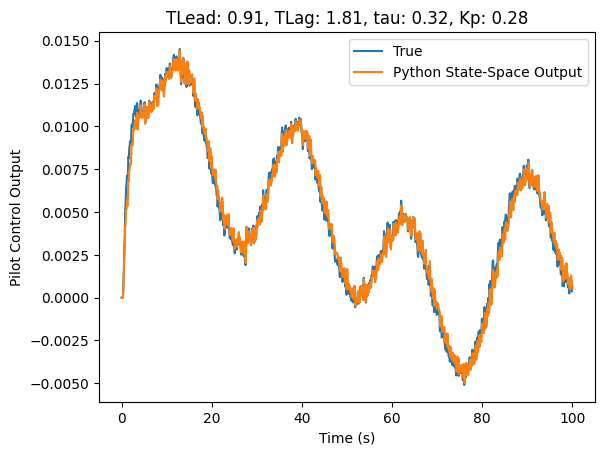

In [ ]:
test_run = random.randint(0, 749-1)
plt.plot(time, p_tensor[:,test_run], label = 'True')

TLd_r,TLg_r,tau_r,Kp_r =  tlds_tensor[:,test_run].mean(), tlgs_tensor[:,test_run].mean(), taus_tensor[:,test_run].mean(), kps_tensor[:,test_run].mean()


# Step 2: Compute A1_r, A2_r, B1_r, B2_r, and the state-space matrices
A1_r = (2 * TLg_r + tau_r) / (tau_r * TLg_r)
A2_r = 2 / (tau_r * TLg_r)
b0_r = TLd_r * -Kp_r / TLg_r
b1_r = (2 * TLd_r - tau_r) * -Kp_r / (tau_r * TLg_r)
b2_r = (2 * -Kp_r) / (tau_r * TLg_r)

B1_r = b1_r - b0_r * A1_r
B2_r = b2_r - b0_r * A2_r

# Step 3: Define the state-space matrices A, B, C, D
A = np.array([[-A1_r, -A2_r], [1, 0]])  # State matrix
B = np.array([[1], [0]])  # Input matrix (column vector)
C = np.array([B1_r, B2_r])  # Output matrix
D = b0_r  # Direct transmission matrix

# Step 4: Create the state-space system
system_ss = signal.StateSpace(A, B, C, D)

'''
# Step 5: Define the time vector and input signal (replace e_t with actual input signal)
t = np.linspace(0, 10, 1000)  # Time vector from 0 to 10 seconds
e_t = np.sin(t)  # Example input signal (e.g., sine wave)

# Step 6: Simulate the system
t_out, y_out, _ = signal.lsim(system_ss, U=e_t, T=t)
'''




# Create the state-space system
system_ss = signal.StateSpace(A, B, C, D)
# Simulate the system
u = np.array(pitch_error_tensor[:,test_run])
t = np.linspace(0, 100, 1000)  # Simulate for 10 seconds with 1000 point
t_out, y_out, x_out = signal.lsim(system_ss, U=np.array(u).squeeze(), T=t, X0=[0,0])
pilot_output_estimated = torch.tensor(y_out).view(1, -1)

plt.plot(t_out, y_out, label='Python State-Space Output')

plt.xlabel('Time (s)')
plt.ylabel('Pilot Control Output')
plt.legend()
plt.title(f'TLead: {TLd_r:.2f}, TLag: {TLg_r:.2f}, tau: {tau_r:.2f}, Kp: {Kp_r:.2f}')
plt.show();

## Normalize data

In [ ]:
pitch_cmd_tensor_norm = (pitch_cmd_tensor - pitch_cmd_tensor.min(dim=0).values) / (pitch_cmd_tensor.max(dim=0).values - pitch_cmd_tensor.min(dim=0).values)
pitch_out_tensor_norm = (pitch_out_tensor - pitch_out_tensor.min(dim=0).values) / (pitch_out_tensor.max(dim=0).values - pitch_out_tensor.min(dim=0).values)
pitch_error_tensor_norm = (pitch_error_tensor - pitch_error_tensor.min(dim=0).values) / (pitch_error_tensor.max(dim=0).values - pitch_error_tensor.min(dim=0).values)

In [ ]:
pilot_output_tensor_norm = (p_tensor - p_tensor.min(dim=0).values) / (p_tensor.max(dim=0).values - p_tensor.min(dim=0).values)

In [ ]:
has_nan = torch.isnan(pitch_out_tensor_norm).any().item()
has_inf = torch.isinf(pitch_out_tensor_norm).any().item()
if has_nan:
    print("Tensor contains NaN values.")
if has_inf:
    print("Tensor contains Infinity values.")

num_nans = torch.isnan(pitch_out_tensor_norm).sum().item()
num_infs = torch.isinf(pitch_out_tensor_norm).sum().item()

print("Number of NaNs:", num_nans)
print("Number of Infs:", num_infs)

Number of NaNs: 0
Number of Infs: 0


In [ ]:
time_norm = (time - time.min(dim=0).values) / (time.max(dim=0).values - time.min(dim=0).values)

## Create X

In [ ]:
tensor_list = []
for i in range(tlds_tensor.shape[1]):
  tensor_2d = (torch.cat((pitch_cmd_tensor_norm[:,i].view(-1,1), pitch_out_tensor_norm[:,i].view(-1,1),pitch_error_tensor_norm[:,i].view(-1,1),time_norm[:]),dim=1))
  tensor_list.append(tensor_2d)
X = torch.stack(tensor_list)
X.shape #this is in the shape of (# of runs, data points, # of features)

torch.Size([743, 1000, 4])

In [ ]:
tensor_list = []
for i in range(tlds_tensor.shape[1]):
  tensor_2d = (torch.cat((pitch_cmd_tensor_norm[:,i].view(-1,1), pitch_out_tensor_norm[:,i].view(-1,1),pitch_error_tensor_norm[:,i].view(-1,1),pilot_output_tensor_norm[:,i].view(-1,1), time_norm[:]),dim=1))
  tensor_list.append(tensor_2d)
X = torch.stack(tensor_list)
X.shape #this is in the shape of (# of runs, data points, # of features)

torch.Size([743, 1000, 5])

## Create y

In [ ]:
tlds_tensor_2 =  tlds_tensor.T
tlgs_tensor_2 = tlgs_tensor.T
taus_tensor_2 = taus_tensor.T
kps_tensor_2 = kps_tensor.T
tlds_tensor_2.shape

tensor_list = []
for j in range(tlds_tensor.shape[1]):
  row_tensor = torch.concat((tlds_tensor_2[j,:].view(1,-1),tlgs_tensor_2[j,:].view(1,-1),taus_tensor_2[j,:].view(1,-1), kps_tensor_2[j,:].view(1,-1)),dim=1)
  tensor_list.append(row_tensor)

y = torch.stack(tensor_list)
y=torch.squeeze(y)
y.shape

torch.Size([743, 4000])

## Train/Test split

In [ ]:
p_tensor.T.shape, pitch_error_tensor.T.shape

(torch.Size([743, 1000]), torch.Size([743, 1000]))

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

Xtrain, Xtest, pitcherrortrain, pitcherrortest, ptrain, ptest, ytrain, ytest = train_test_split(
    X, pitch_error_tensor.T, p_tensor.T, y,
    test_size=0.2,        # Proportion of the dataset to include in the test split
    random_state=123       # Seed for the random number generator
)

Xtrain.shape, Xtest.shape, pitcherrortrain.shape, pitcherrortest.shape, ptrain.shape, ptest.shape, ytrain.shape, ytest.shape

(torch.Size([594, 1000, 5]),
 torch.Size([149, 1000, 5]),
 torch.Size([594, 1000]),
 torch.Size([149, 1000]),
 torch.Size([594, 1000]),
 torch.Size([149, 1000]),
 torch.Size([594, 4000]),
 torch.Size([149, 4000]))

In [ ]:
Xtrain_flattened = Xtrain.reshape(Xtrain.shape[0], -1)
Xtrain_flattened.shape

torch.Size([594, 5000])

In [ ]:
Xtest_flattened = Xtest.reshape(Xtest.shape[0], -1)
Xtest_flattened.shape

torch.Size([149, 5000])

### Train/Test visualization

In [ ]:
ytrain.shape, ytest.shape

(torch.Size([594, 4000]), torch.Size([149, 4000]))

In [ ]:
tldstrain = ytrain[:,:1000]
tlgsstrain = ytrain[:,1000:2000]
tausstrain = ytrain[:,2000:3000]
kpstrain = ytrain[:,3000:4000]

tldstrain_avg = tldstrain.mean(axis=1, keepdims=True)
tlgsstrain_avg = tlgsstrain.mean(axis=1, keepdims=True)
tausstrain_avg = tausstrain.mean(axis=1, keepdims=True)
kpstrain_avg = kpstrain.mean(axis=1, keepdims=True)

tldstrain_avg.shape, tlgsstrain_avg.shape, tausstrain_avg.shape, kpstrain_avg.shape

(torch.Size([594, 1]),
 torch.Size([594, 1]),
 torch.Size([594, 1]),
 torch.Size([594, 1]))

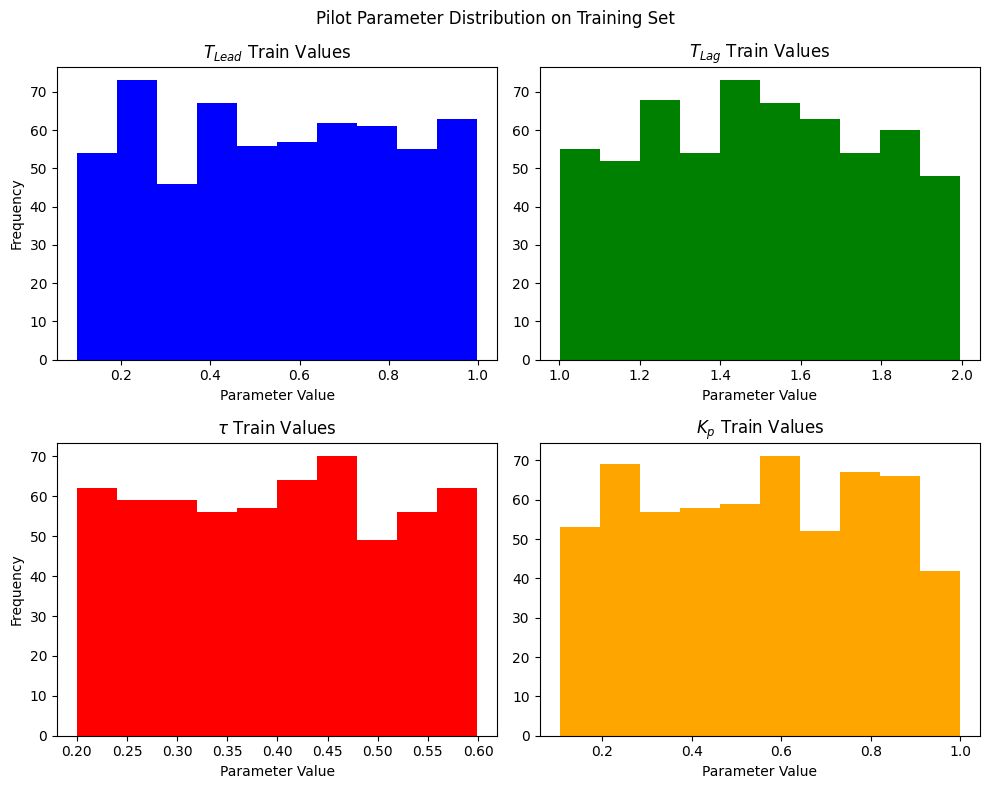

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0,0].hist(tldstrain_avg.squeeze(), color='blue')
axs[0,0].set_title(r'$T_{Lead}$ Train Values')
axs[0,0].set_xlabel('Parameter Value')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(tlgsstrain_avg.squeeze(), color='green')
axs[0,1].set_title(r'$T_{Lag}$ Train Values')
axs[0,1].set_xlabel('Parameter Value')

axs[1,0].hist(tausstrain_avg.squeeze(), color='red')
axs[1,0].set_title(r'$\tau$ Train Values')
axs[1,0].set_xlabel('Parameter Value')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(kpstrain_avg.squeeze(), color='orange')
axs[1,1].set_title(r'$K_{p}$ Train Values')
axs[1,1].set_xlabel('Parameter Value')
#axs[1,1].set_ylabel('Frequency')

fig.suptitle('Pilot Parameter Distribution on Training Set');


plt.tight_layout()
plt.show()

In [ ]:
tldstest = ytest[:,:1000]
tlgsstest = ytest[:,1000:2000]
tausstest = ytest[:,2000:3000]
kpstest = ytest[:,3000:4000]

tldstest_avg = tldstest.mean(axis=1, keepdims=True)
tlgsstest_avg = tlgsstest.mean(axis=1, keepdims=True)
tausstest_avg = tausstest.mean(axis=1, keepdims=True)
kpstest_avg = kpstest.mean(axis=1, keepdims=True)

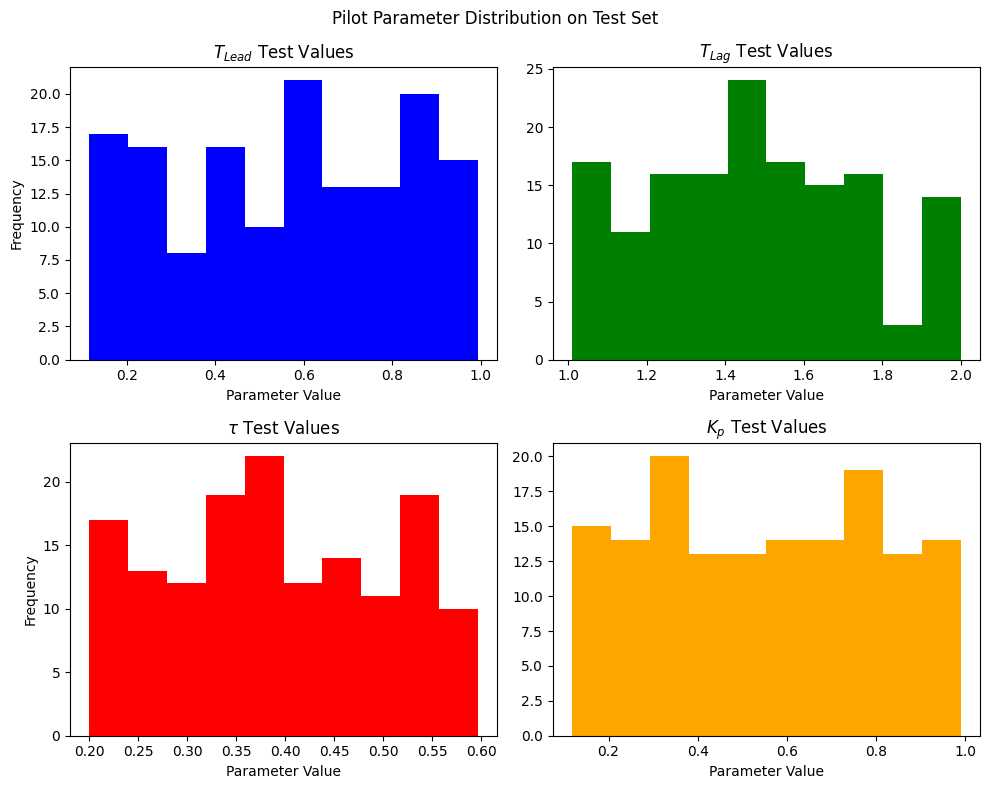

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0,0].hist(tldstest_avg.squeeze(), color='blue')
axs[0,0].set_title(r'$T_{Lead}$ Test Values')
axs[0,0].set_xlabel('Parameter Value')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(tlgsstest_avg.squeeze(), color='green')
axs[0,1].set_title(r'$T_{Lag}$ Test Values')
axs[0,1].set_xlabel('Parameter Value')

axs[1,0].hist(tausstest_avg.squeeze(), color='red')
axs[1,0].set_title(r'$\tau$ Test Values')
axs[1,0].set_xlabel('Parameter Value')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(kpstest_avg.squeeze(), color='orange')
axs[1,1].set_title(r'$K_{p}$ Test Values')
axs[1,1].set_xlabel('Parameter Value')
#axs[1,1].set_ylabel('Frequency')

fig.suptitle('Pilot Parameter Distribution on Test Set');

plt.tight_layout()
plt.show()

# Create NN

In [ ]:
# Create dense model
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(Xtrain_flattened.shape[1], 256)
        #self.layer2 = nn.Linear(256, 256)
        #self.layer3 = nn.Linear(256, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, ytrain.shape[1])

        # Apply Glorot initialization to the linear layers
        #nn.init.xavier_uniform_(self.layer1.weight)
        #nn.init.xavier_uniform_(self.layer2.weight)
        #nn.init.xavier_uniform_(self.layer3.weight)
        #nn.init.xavier_uniform_(self.layer4.weight)
        #nn.init.xavier_uniform_(self.layer5.weight)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        #x = torch.relu(self.layer2(x))
        #x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        x[3000:4000] = 0.1 + 0.9 * torch.sigmoid(x[2000:3000])
        return x

# Create an instance of the model
model_1 = DenseModel()

# Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(123)
# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, additional_data1, additional_data2):
        self.X_train = X_train
        self.y_train = y_train
        self.additional_data1 = additional_data1
        self.additional_data2 = additional_data2

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        additional1 = self.additional_data1[idx]
        additional2 = self.additional_data2[idx]
        return x, y, additional1, additional2

# Define batch size
batch_size = 32

# Create the custom dataset
custom_dataset = CustomDataset(X_train=Xtrain_flattened, y_train=ytrain, additional_data1=ptrain, additional_data2=pitcherrortrain)

# Create DataLoader with shuffle=False
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)


# Setup training parameters

In [ ]:
torch.manual_seed(123)

# define the optimiser
optimiser = torch.optim.Adam(model_1.parameters(), lr=1e-3)

# define the number of epochs
epochs = 50

# collect the loss history
total_loss_history=[]
pilot_output_loss_history=[]
xpilot_calcualted_loss_history=[]
params_loss_history=[]


# define the loss criteria
criterion= nn.MSELoss()

# Training Loop

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


torch.manual_seed(123)

switch_epoch = 5
for epoch in range(epochs):

    model_1.train()

    tensor_list = []
    xpilot_list=[]

    for batch_X, batch_y, batch_additional1, batch_additional2 in train_loader:

      # Zero the gradients
      optimiser.zero_grad()

      # Forward pass
      params_est = model_1(batch_X)

      # Compute parameters loss
      params_loss = criterion(params_est, batch_y)
      params_loss_history.append(params_loss.item())

      if epoch >= switch_epoch:
        # Compute physics losses
        for x in range(batch_X.shape[0]):
            tld,tlg,tau,kp = params_est[x,:1000].mean(),params_est[x,1000:2000].mean(),params_est[x,2000:3000].mean(), params_est[x,3000:4000].mean()

            # Calculate estimated pilot output
            with torch.no_grad():
                TLd_r,TLg_r,tau_r,Kp_r =  tld, tlg, tau, kp


                # Step 2: Compute A1_r, A2_r, B1_r, B2_r, and the state-space matrices
                A1_r = (2 * TLg_r + tau_r) / (tau_r * TLg_r)
                A2_r = 2 / (tau_r * TLg_r)
                b0_r = TLd_r * -Kp_r / TLg_r
                b1_r = (2 * TLd_r - tau_r) * -Kp_r / (tau_r * TLg_r)
                b2_r = (2 * -Kp_r) / (tau_r * TLg_r)

                B1_r = b1_r - b0_r * A1_r
                B2_r = b2_r - b0_r * A2_r

                # Step 3: Define the state-space matrices A, B, C, D
                A = np.array([[-A1_r, -A2_r], [1, 0]])  # State matrix
                B = np.array([[1], [0]])  # Input matrix (column vector)
                C = np.array([B1_r, B2_r])  # Output matrix
                D = b0_r  # Direct transmission matrix

                # Step 4: Create the state-space system
                system_ss = signal.StateSpace(A, B, C, D)

                # Create the state-space system
                system_ss = signal.StateSpace(A, B, C, D)
                # Simulate the system
                u = batch_additional2[x,:]
                t = np.linspace(0, 100, 1000)  # Simulate for 10 seconds with 1000 point
                t_out, y_out, x_out = signal.lsim(system_ss, U= np.array(u).squeeze(), T=t, X0=[0,0])
                pilot_output_estimated = torch.tensor(y_out).view(1, -1)
                tensor_list.append(pilot_output_estimated)

        # Concatenate all pilot outputs after the loop
        pilot_output_concat = torch.cat(tensor_list, dim=0)

        # Compute the loss over the entire batch
        pilot_output_loss = criterion(pilot_output_concat, batch_additional1)
        pilot_output_loss_history.append(pilot_output_loss.item())

        # Clear tensor_list after processing the entire batch
        tensor_list.clear()



      if epoch < switch_epoch:
        loss = params_loss
      else:
        loss = params_loss + pilot_output_loss
      total_loss_history.append(loss.item())

      # Backward pass
      loss.backward()


      # Update step
      optimiser.step()
    print(f'Epoch {epoch+1}/{epochs}')

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [ ]:
pilot_output_estimated.shape, pilot_output_concat.shape, batch_additional1.shape

(torch.Size([1, 1000]), torch.Size([18, 1000]), torch.Size([18, 1000]))

# Testing and Results

## Loss history

In [ ]:
epochs_batch = torch.tensor(total_loss_history[:]).reshape(-1,len(train_loader))
epochs_batch1 = torch.mean(epochs_batch,dim=1)
epochs_batch1.shape

torch.Size([50])

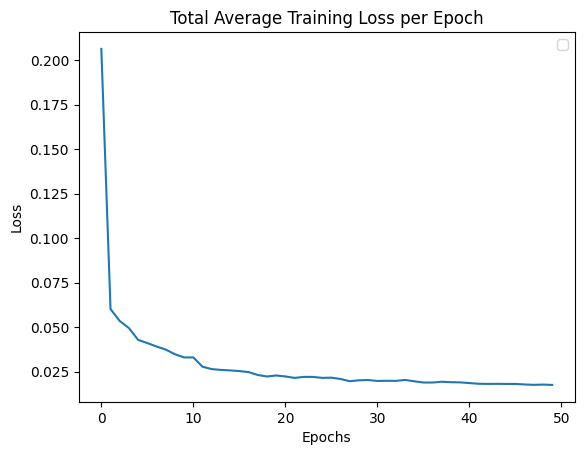

In [ ]:
plt.plot(epochs_batch1[:])


plt.xlabel('Epochs')
plt.legend()
plt.title('Total Average Training Loss per Epoch');
plt.ylabel('Loss');

## Parameter errors

In [ ]:
model_1.eval()

with torch.no_grad():

  # grab estimated params
  estimated_params = model_1(Xtest_flattened)
  tld_est,tlg_est,tau_est,kp_est = estimated_params[:,:1000],estimated_params[:,1000:2000],estimated_params[:,2000:3000],estimated_params[:,3000:4000]


  # grab true params
  true_params = ytest
  tld_true,tlg_true,tau_true,kp_true = true_params[:,:1000],true_params[:,1000:2000],true_params[:,2000:3000],true_params[:,3000:4000]

  from sklearn.metrics import mean_absolute_error, mean_squared_error
  tld_mse = mean_squared_error(tld_true,tld_est)
  tlg_mse = mean_squared_error(tlg_true,tlg_est)
  tau_mse = mean_squared_error(tau_true,tau_est)
  kp_mse = mean_squared_error(kp_true,kp_est)

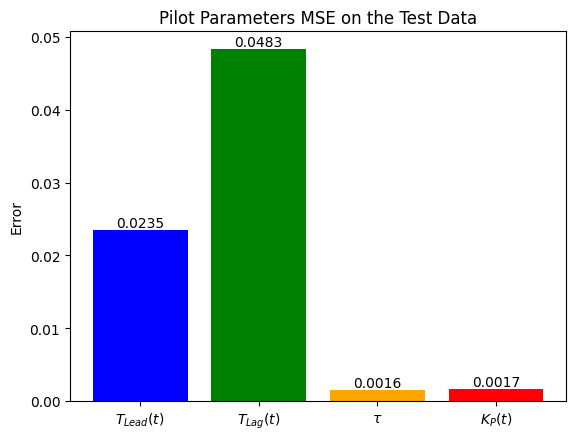

In [ ]:
values = [tld_mse, tlg_mse, tau_mse, kp_mse]

# Corresponding labels for each value
labels = ["$T_{Lead}(t)$", "$T_{Lag}(t)$", r"$\tau$", "$K_{P}(t)$"]

# Specify colors for each bar
colors = ['blue', 'green', 'orange','red']

# Create a bar plot
plt.bar(labels, values,color=colors)

# Add labels to each bar
for label, value in zip(labels, values):
    plt.text(label, value , '{:.4f}'.format(value), ha='center', va='bottom')

# Add labels and title
plt.title('Pilot Parameters MSE on the Test Data')
plt.ylabel('Error')
#plt.title('Bar Plot of Four Values')

# Display the plot
plt.show()

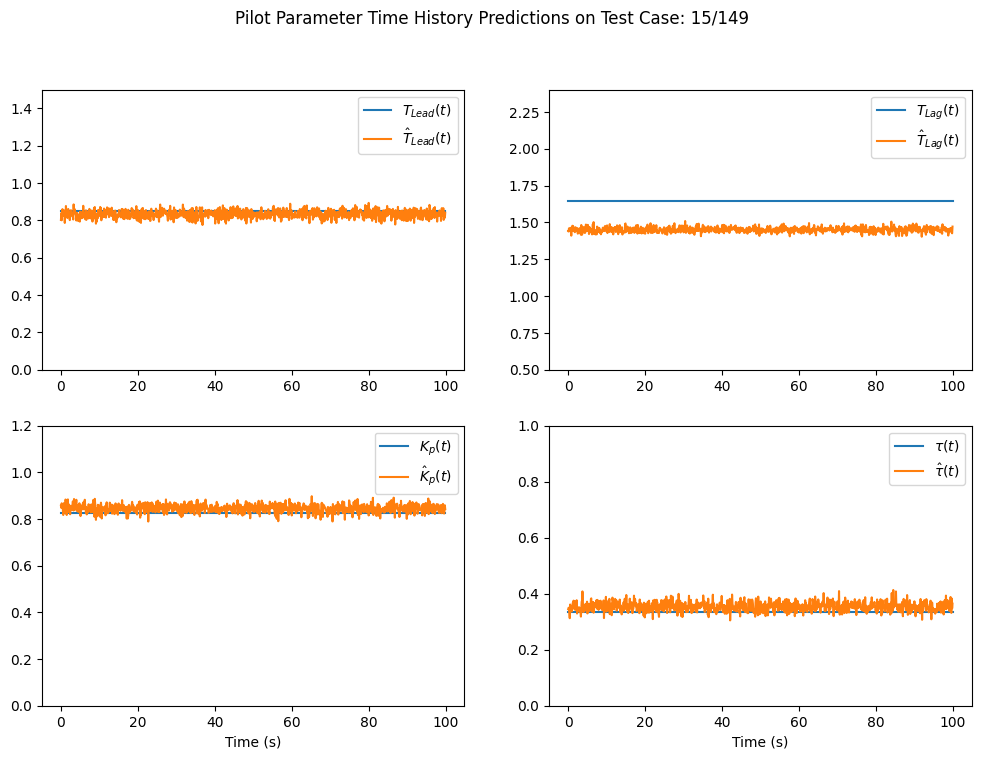

In [ ]:
# lets see a sample parameters time history

test_run = random.randint(0, len(Xtest_flattened)-1)
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].plot(time, tld_true[test_run,:], label= "$T_{Lead}(t)$")
axs[0,0].plot(time, tld_est[test_run,:], label= "$\hat{T}_{Lead}(t)$")
#axs[0,0].set_title(f'Parameter Time History Predictions on Test Case: {test_run}/{len(Xtest_flattened)}')
axs[0,0].set_ylim(0, 1.5)

axs[0,1].plot(time, tlg_true[test_run,:], label= "$T_{Lag}(t)$")
axs[0,1].plot(time, tlg_est[test_run,:], label= "$\hat{T}_{Lag}(t)$")
axs[0,1].set_ylim(0.5, 2.4)

axs[1,0].plot(time, kp_true[test_run,:], label= "$K_{p}(t)$")
axs[1,0].plot(time, kp_est[test_run,:], label= "$\hat{K}_{p}(t)$")
axs[1,0].set_ylim(0, 1.2)

axs[1,1].plot(time, tau_true[test_run,:], label= r"$\tau(t)$")
axs[1,1].plot(time, tau_est[test_run,:], label= r"$\hat{\tau}(t)$")
axs[1,1].set_ylim(0, 1)

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

axs[1,0].set_xlabel('Time (s)')
axs[1,1].set_xlabel('Time (s)')

plt.suptitle(f'Pilot Parameter Time History Predictions on Test Case: {test_run}/{len(Xtest_flattened)}')

plt.show()

## p(t) errors

In [ ]:
params_preds = torch.cat((tld_est.mean(dim = 1).unsqueeze(1), tlg_est.mean(dim = 1).unsqueeze(1), tau_est.mean(dim = 1).unsqueeze(1), kp_est.mean(dim = 1).unsqueeze(1)), dim=1)
params_preds.shape, pitcherrortest.shape, np.array(pitcherrortest[test_run,:]).shape

(torch.Size([149, 4]), torch.Size([149, 1000]), (1000,))

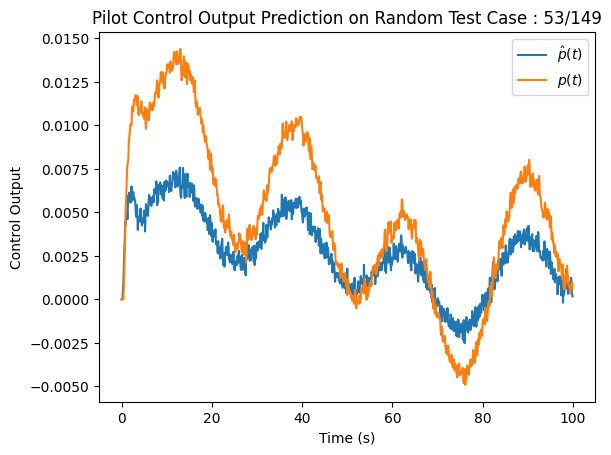

In [ ]:
#test_run = random.randint(0, len(Xtest_flattened)-1)
test_run = random.randint(0, len(Xtest_flattened)-1)
tld,tlg,tau,kp = params_preds[test_run,0],params_preds[test_run,1],params_preds[test_run,2],params_preds[test_run,3]

TLd_r,TLg_r,tau_r,Kp_r =  tld, tlg, tau, kp


# Step 2: Compute A1_r, A2_r, B1_r, B2_r, and the state-space matrices
A1_r = (2 * TLg_r + tau_r) / (tau_r * TLg_r)
A2_r = 2 / (tau_r * TLg_r)
b0_r = TLd_r * -Kp_r / TLg_r
b1_r = (2 * TLd_r - tau_r) * -Kp_r / (tau_r * TLg_r)
b2_r = (2 * -Kp_r) / (tau_r * TLg_r)

B1_r = b1_r - b0_r * A1_r
B2_r = b2_r - b0_r * A2_r

# Step 3: Define the state-space matrices A, B, C, D
A = np.array([[-A1_r, -A2_r], [1, 0]])  # State matrix
B = np.array([[1], [0]])  # Input matrix (column vector)
C = np.array([B1_r, B2_r])  # Output matrix
D = b0_r  # Direct transmission matrix

# Step 4: Create the state-space system
system_ss = signal.StateSpace(A, B, C, D)

# Create the state-space system
system_ss = signal.StateSpace(A, B, C, D)
# Simulate the system
u = batch_additional2[x,:]
t = np.linspace(0, 100, 1000)  # Simulate for 10 seconds with 1000 point
t_out, y_out, x_out = signal.lsim(system_ss, U= np.array(u).squeeze(), T=t, X0=[0,0])
pilot_output_estimated = torch.tensor(y_out).view(1, -1)

plt.plot(time,pilot_output_estimated.squeeze(),label="$\hat{p}(t)$")
plt.plot(time, ptest[test_run,:], label="$p(t)$")
plt.xlabel('Time (s)')
plt.ylabel('Control Output')
plt.legend()
plt.title(f'Pilot Control Output Prediction on Random Test Case : {test_run}/{len(Xtest_flattened)}');
#plt.title(f'P(t) Predictions on Test Case: {test_run}/{len(Xtest_flattened)}');

In [ ]:
# Initialize an empty list to store the tensors
pilot_output_predicted_list = []

for k in range(len(Xtest_flattened)):
  tld_est_int = tld_est[k,:].mean()
  tlg_est_int = tlg_est[k,:].mean()
  tau_est_int = tau_est[k,:].mean()
  kp_est_int = kp_est[k,:].mean()

  tld_est_int,tlg_est_int,tau_est_int,kp_est_int =  tld, tlg, tau, kp


  # Step 2: Compute A1_r, A2_r, B1_r, B2_r, and the state-space matrices
  A1_r = (2 * TLg_r + tau_r) / (tau_r * TLg_r)
  A2_r = 2 / (tau_r * TLg_r)
  b0_r = TLd_r * -Kp_r / TLg_r
  b1_r = (2 * TLd_r - tau_r) * -Kp_r / (tau_r * TLg_r)
  b2_r = (2 * -Kp_r) / (tau_r * TLg_r)

  B1_r = b1_r - b0_r * A1_r
  B2_r = b2_r - b0_r * A2_r

  # Step 3: Define the state-space matrices A, B, C, D
  A = np.array([[-A1_r, -A2_r], [1, 0]])  # State matrix
  B = np.array([[1], [0]])  # Input matrix (column vector)
  C = np.array([B1_r, B2_r])  # Output matrix
  D = b0_r  # Direct transmission matrix

  # Step 4: Create the state-space system
  system_ss = signal.StateSpace(A, B, C, D)

  # Create the state-space system
  system_ss = signal.StateSpace(A, B, C, D)
  # Simulate the system
  u = pitcherrortest[x,:]
  t = np.linspace(0, 100, 1000)  # Simulate for 10 seconds with 1000 point
  t_out, y_out, x_out = signal.lsim(system_ss, U= np.array(u).squeeze(), T=t, X0=[0,0])
  pilot_output_estimated = torch.tensor(y_out).view(1, -1)
  pilot_output_predicted = pilot_output_estimated.squeeze()

  # Append to the list
  pilot_output_predicted_list.append(pilot_output_predicted)


# Convert the list to a 2D tensor (NumPy array)
pilot_output_predicted_tensor = np.stack(pilot_output_predicted_list)

pilot_output_predicted_tensor.shape, ptest.shape

((149, 1000), torch.Size([149, 1000]))

In [ ]:
mean_squared_error(ptest,pilot_output_predicted_tensor)

3.3496462181619407e-06

# save the model

In [ ]:
#torch.save(model_1.state_dict(), 'model_state_dict_5.pth') 